In [80]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score

from sklearn import model_selection
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [67]:
import sklearn

In [2]:
pd.set_option('display.max_columns',None)

## Import cleaned dataset
### Simple model using just Abn% + demographics

In [17]:
pos_final_test = pd.read_csv('./pos_final_test.csv.gz', compression='gzip')

model_cols = pos_final_test.columns.str.contains('abn') | pos_final_test.columns.isin(['gender', 'age','ethnicity_AMERICAN INDIAN/ALASKA NATIVE', 'ethnicity_ASIAN','ethnicity_BLACK/AFRICAN AMERICAN', 'ethnicity_HISPANIC/LATINO','ethnicity_OTHER', 'ethnicity_UNKNOWN'])
hadm_features = pos_final_test.loc[:, model_cols]
hadm_target = pos_final_test.loc[:, 'pos']

In [41]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# hadm_features['ethnicity'] = le.fit_transform(hadm_features['ethnicity'])
# hadm_features['gender'] = le.fit_transform(hadm_features['gender'])

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# hadm_features['age'] = scaler.fit_transform(hadm_features['age'].values.reshape(-1, 1))

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Train test split

In [19]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(hadm_features, hadm_target, test_size=.2, stratify=hadm_target, random_state=25)

In [20]:
# Over and under sample the train set
sm = SMOTE()
X_res_over, y_res_over = sm.fit_resample(X_train, y_train)

nm = NearMiss()
X_res_under, y_res_under = nm.fit_resample(X_train, y_train)

In [21]:
# check target counts
print('Target=0: ',hadm_target[hadm_target==0].count())
print('Target=1: ',hadm_target[hadm_target==1].count())

Target=0:  7539
Target=1:  1199


In [65]:
def results(model):
    '''
    Function to report on the metrics of a GridSearch model.
    Input: GridSearchCV model
    Prints: CV score, best parameters, accuracy, precision, recall, F1, confusion matrix and ROCAUC
    '''
    
#     cross validation scores
    print("Cross Validation")
    print("-" * 20)
    print("Best parameter: ", model.best_params_)
    print("Best CV score:  %.4f" % model.best_score_)

#     confusion matrix & related scores
    pred = model.best_estimator_.predict(X_test)
    print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print("Classification Report:", end='')
    print(f"\tPrecision Score: {precision_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tRecall Score: {recall_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tF1 score: {f1_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
    
    svc_disp = plot_roc_curve(model, X_test, y_test)
    plt.show()
    
    if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
        est_coefs = pd.Series(model.best_estimator_.coef_[0], index=X_train.columns)
        sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
        print(sortedCoefs[sortedCoefs > 0].head(50))

        
    else:
        est_coefs = pd.Series(model.best_estimator_.feature_importances_, index=X_train.columns)
        sortedCoefs = est_coefs.sort_values(ascending=False)
        print(sortedCoefs.head(50))

## Logistic Regression

### Basic

Cross Validation
--------------------
Best parameter:  {'C': 1}
Best CV score:  0.7787
Accuracy Score: 78.15%
_______________________________________________
Classification Report:	Precision Score: 36.08%
			Recall Score: 76.67%
			F1 score: 49.07%
_______________________________________________
Confusion Matrix: 
 [[1182  326]
 [  56  184]]



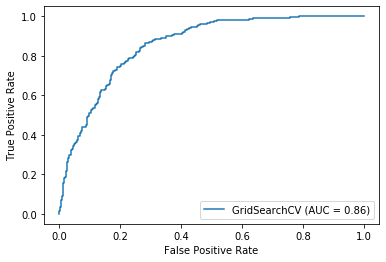

CPU times: user 3.87 s, sys: 307 ms, total: 4.17 s
Wall time: 3.13 s


In [23]:
%%time

params ={'C':range(1, 1000, 300)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log = GridSearchCV(estimator = logReg, param_grid = params, cv = 3)
grid_log.fit(X_train, y_train)
grid_log.best_score_

results(grid_log)

### Over Sampling using SMOTE

In [25]:
%%time
params ={'C':range(1, 1000, 300)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log_over = GridSearchCV(estimator = logReg, param_grid = params, cv = 3)
grid_log_over.fit(X_res_over, y_res_over)

CPU times: user 3.66 s, sys: 277 ms, total: 3.94 s
Wall time: 3.09 s


0.7993708197799035

Cross Validation
--------------------
Best parameter:  {'C': 1}
Best CV score:  0.7994
Accuracy Score: 79.00%
_______________________________________________
Classification Report:	Precision Score: 36.11%
			Recall Score: 68.75%
			F1 score: 47.35%
_______________________________________________
Confusion Matrix: 
 [[1216  292]
 [  75  165]]



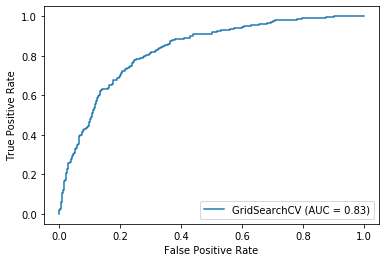

ethnicity_OTHER                            2.372791
ethnicity_ASIAN                            2.230786
ethnicity_UNKNOWN                          1.933593
ethnicity_HISPANIC/LATINO                  1.575141
ethnicity_BLACK/AFRICAN AMERICAN           1.316682
age                                        0.768457
ethnicity_AMERICAN INDIAN/ALASKA NATIVE    0.602819
('abn_percent', 51006)                     0.496783
('abn_percent', 51277)                     0.416408
('abn_percent', 51003)                     0.386802
('abn_percent', 51221)                     0.370190
('abn_percent', 51222)                     0.366403
('abn_percent', 51274)                     0.283418
('abn_percent', 50931)                     0.247459
('abn_percent', 50885)                     0.224886
('abn_percent', 50878)                     0.219331
('abn_percent', 50893)                     0.210747
gender                                     0.206070
('abn_percent', 51484)                     0.152074
('abn_percen

In [26]:
results(grid_log_over)

### Under Sampling using Near Miss

In [27]:
%%time
params ={'C':range(1, 1000, 300)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log_under = GridSearchCV(estimator = logReg, param_grid = params, cv = 3)
grid_log_under.fit(X_res_under, y_res_under)
grid_log_under.best_score_

CPU times: user 1.49 s, sys: 124 ms, total: 1.62 s
Wall time: 1.02 s


0.9233413210745957

Cross Validation
--------------------
Best parameter:  {'C': 1}
Best CV score:  0.9233
Accuracy Score: 44.85%
_______________________________________________
Classification Report:	Precision Score: 19.06%
			Recall Score: 92.92%
			F1 score: 31.63%
_______________________________________________
Confusion Matrix: 
 [[561 947]
 [ 17 223]]



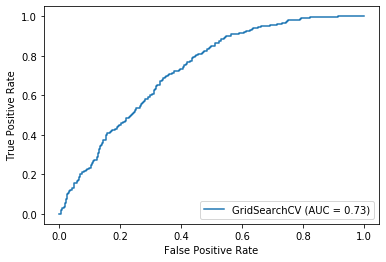

('abn_percent', 50861)              1.290620
('abn_percent', 50863)              1.156911
('abn_percent', 51265)              1.020661
('abn_percent', 50983)              0.991233
('abn_percent', 50971)              0.958114
('abn_percent', 51277)              0.947703
('abn_percent', 51466)              0.811735
ethnicity_BLACK/AFRICAN AMERICAN    0.773682
('abn_percent', 50882)              0.751875
age                                 0.714044
('abn_percent', 51003)              0.675131
('abn_percent', 50970)              0.660517
('abn_percent', 51250)              0.652908
('abn_percent', 51478)              0.639146
('abn_percent', 51249)              0.594506
('abn_percent', 51248)              0.593144
('abn_percent', 51006)              0.571152
('abn_percent', 50911)              0.566987
('abn_percent', 50960)              0.556957
('abn_percent', 51514)              0.529334
('abn_percent', 51275)              0.529010
('abn_percent', 51486)              0.503801
ethnicity_

In [28]:
results(grid_log_under)

## Random Forest

### Basic

In [29]:
%%time
param_grid={'criterion': ['entropy','gini'],
            'n_estimators': range(1,500,50),
            'max_depth': range(10,110,20)
            }

grid_rf = model_selection.GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv=3)
grid_rf.fit(X_train, y_train)

CPU times: user 6min 23s, sys: 7.38 s, total: 6min 30s
Wall time: 6min 35s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(10, 110, 20),
                         'n_estimators': range(1, 500, 50)})

Cross Validation
--------------------
Best parameter:  {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 401}
Best CV score:  0.8751
Accuracy Score: 87.64%
_______________________________________________
Classification Report:	Precision Score: 73.08%
			Recall Score: 15.83%
			F1 score: 26.03%
_______________________________________________
Confusion Matrix: 
 [[1494   14]
 [ 202   38]]



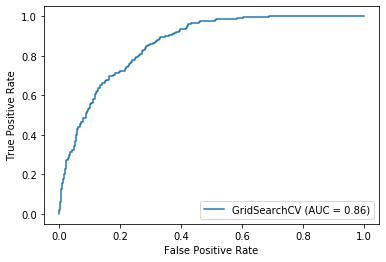

age                                        0.119673
('abn_percent', 51006)                     0.110407
('abn_percent', 50912)                     0.082276
('abn_percent', 51003)                     0.065809
('abn_percent', 51277)                     0.049472
('abn_percent', 50931)                     0.039504
('abn_percent', 51274)                     0.036257
('abn_percent', 51237)                     0.036081
('abn_percent', 50882)                     0.032344
('abn_percent', 50970)                     0.029921
('abn_percent', 51249)                     0.028978
('abn_percent', 51275)                     0.027866
('abn_percent', 50893)                     0.025473
('abn_percent', 50902)                     0.023338
('abn_percent', 51301)                     0.021984
('abn_percent', 50971)                     0.020751
('abn_percent', 51265)                     0.020201
('abn_percent', 51222)                     0.018246
('abn_percent', 51221)                     0.017700
('abn_percen

In [41]:
results(grid_rf)

### Over Sampling using SMOTE

In [48]:
%%time
param_grid={'criterion': ['gini'],
            'n_estimators': range(1,500,50),
            'max_depth': range(10,50,20)
            }

grid_rf_over = model_selection.GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv=3)
grid_rf_over.fit(X_res_over, y_res_over)

CPU times: user 2min 43s, sys: 2.69 s, total: 2min 46s
Wall time: 2min 47s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': range(10, 50, 20),
                         'n_estimators': range(1, 500, 50)})

Cross Validation
--------------------
Best parameter:  {'criterion': 'gini', 'max_depth': 30, 'n_estimators': 301}
Best CV score:  0.9138
Accuracy Score: 85.81%
_______________________________________________
Classification Report:	Precision Score: 48.32%
			Recall Score: 47.92%
			F1 score: 48.12%
_______________________________________________
Confusion Matrix: 
 [[1385  123]
 [ 125  115]]



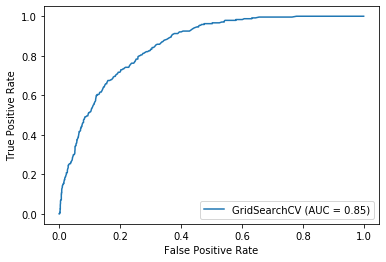

age                                        0.122055
('abn_percent', 51006)                     0.105905
('abn_percent', 50912)                     0.076626
gender                                     0.045537
('abn_percent', 51003)                     0.045033
('abn_percent', 51277)                     0.041372
('abn_percent', 50931)                     0.040759
('abn_percent', 50970)                     0.040686
('abn_percent', 50882)                     0.037252
('abn_percent', 51274)                     0.033680
('abn_percent', 51275)                     0.031315
('abn_percent', 51237)                     0.030438
('abn_percent', 50893)                     0.029893
('abn_percent', 51301)                     0.025128
('abn_percent', 50902)                     0.024796
('abn_percent', 51249)                     0.024437
('abn_percent', 51221)                     0.020788
('abn_percent', 50971)                     0.018914
('abn_percent', 51265)                     0.017714
('abn_percen

In [49]:
results(grid_rf_over)

### Under Sampling using Near Miss

Cross Validation
--------------------
Best parameter:  {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 51}
Best CV score:  0.9087
Accuracy Score: 51.72%
_______________________________________________
Classification Report:	Precision Score: 21.13%
			Recall Score: 92.08%
			F1 score: 34.37%
_______________________________________________
Confusion Matrix: 
 [[683 825]
 [ 19 221]]



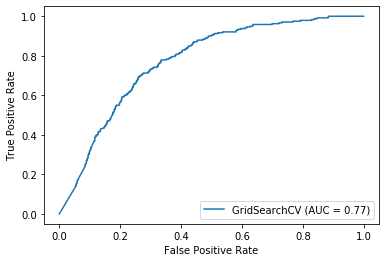

CPU times: user 27 s, sys: 243 ms, total: 27.3 s
Wall time: 27.6 s


In [50]:
%%time
param_grid={'criterion': ['gini'],
            'n_estimators': range(1,501,50),
            'max_depth': range(10,50,20)
            }

grid_rf_under = model_selection.GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv=3)
grid_rf_under.fit(X_res_under, y_res_under)

In [ ]:
results(grid_rf_under)

## Gradient Boost

In [33]:
# additive approach using 1. n_estimators 2. max_depth, min_samples
# perhaps use randomsearch instead of gridsearch
# look at area under curve (AUC)

### basic

Cross Validation
--------------------
Best parameter:  {'n_estimators': 95}
Best CV score:  0.8751
Accuracy Score: 87.13%
_______________________________________________
Classification Report:	Precision Score: 56.88%
			Recall Score: 25.83%
			F1 score: 35.53%
_______________________________________________
Confusion Matrix: 
 [[1461   47]
 [ 178   62]]



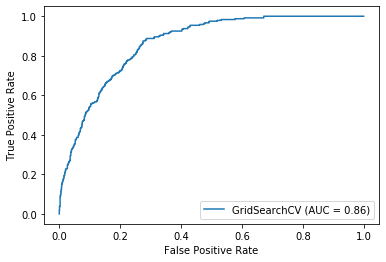

CPU times: user 18.7 s, sys: 232 ms, total: 18.9 s
Wall time: 19.1 s


In [55]:
%%time
param_grid={'n_estimators':range(85,110,5),
            }

grid_gb = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3)
grid_gb.fit(X_train, y_train)

In [ ]:
results(grid_gb)

Cross Validation
--------------------
Best parameter:  {'max_depth': 3, 'max_features': 12, 'min_samples_split': 6, 'n_estimators': 95}
Best CV score:  0.8781
Accuracy Score: 87.53%
_______________________________________________
Classification Report:	Precision Score: 61.00%
			Recall Score: 25.42%
			F1 score: 35.88%
_______________________________________________
Confusion Matrix: 
 [[1469   39]
 [ 179   61]]



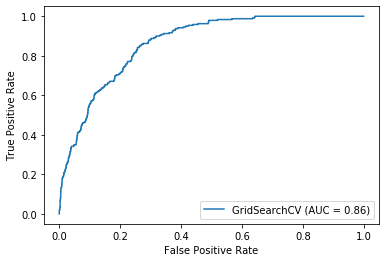

CPU times: user 53.3 s, sys: 670 ms, total: 54 s
Wall time: 54.5 s


In [61]:
%%time
param_grid={'n_estimators':[95],
            'max_depth':range(1,8,2),
            'min_samples_split':range(2,8,2),
            'max_features':range(10,15,2),
            }

grid_gb = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3)
grid_gb.fit(X_train, y_train)


In [ ]:
results(grid_gb)

### Over Sampling using SMOTE¶

In [73]:
%%time
param_grid={'n_estimators':range(120,161,10),
            'max_depth':range(10,13,1),
            }

grid_gb_over = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3)
grid_gb_over.fit(X_res_over, y_res_over)

CPU times: user 13min 44s, sys: 8.7 s, total: 13min 52s
Wall time: 15min 4s


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': range(10, 13),
                         'n_estimators': range(120, 161, 10)})

Cross Validation
--------------------
Best parameter:  {'max_depth': 12, 'n_estimators': 150}
Best CV score:  0.9086
Accuracy Score: 86.16%
_______________________________________________
Classification Report:	Precision Score: 49.52%
			Recall Score: 43.33%
			F1 score: 46.22%
_______________________________________________
Confusion Matrix: 
 [[1402  106]
 [ 136  104]]



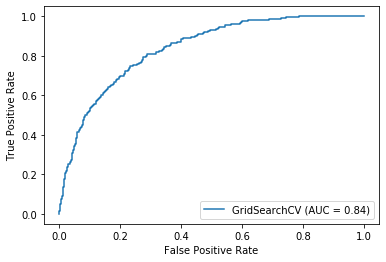

('abn_percent', 51006)                     0.308569
age                                        0.120194
gender                                     0.065190
('abn_percent', 50912)                     0.046589
('abn_percent', 50931)                     0.033402
('abn_percent', 50893)                     0.032212
('abn_percent', 51274)                     0.028017
('abn_percent', 51003)                     0.026271
('abn_percent', 50970)                     0.025380
('abn_percent', 51277)                     0.023298
('abn_percent', 51301)                     0.022504
('abn_percent', 51249)                     0.022244
('abn_percent', 51221)                     0.019728
('abn_percent', 50882)                     0.017675
('abn_percent', 51275)                     0.015628
('abn_percent', 51265)                     0.014290
('abn_percent', 50960)                     0.012975
('abn_percent', 50902)                     0.012375
('abn_percent', 50983)                     0.012180
('abn_percen

In [74]:
results(grid_gb_over)

In [ ]:
%%time
param_grid={'n_estimators':range(20,81,20),
            'max_depth':range(5,16,4),
            'min_samples_split':range(20,100,30),
            'max_features':range(7,20,5),
            }
# 'max_depth': 9, 'n_estimators': 80
grid_gb_over = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3)
grid_gb_over.fit(X_res_over, y_res_over)

results(grid_gb_over)

### Under Sampling using Near Miss

Cross Validation
--------------------
Best parameter:  {'n_estimators': 50}
Best CV score:  0.9150
Accuracy Score: 52.29%
_______________________________________________
Classification Report:	Precision Score: 21.22%
			Recall Score: 91.25%
			F1 score: 34.43%
_______________________________________________
Confusion Matrix: 
 [[695 813]
 [ 21 219]]



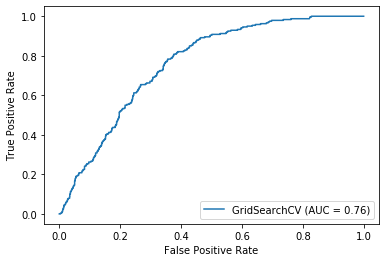

('abn_percent', 51006)                     0.413104
('abn_percent', 51274)                     0.112079
('abn_percent', 50970)                     0.075198
('abn_percent', 51277)                     0.072739
('abn_percent', 50912)                     0.037899
('abn_percent', 51003)                     0.034561
('abn_percent', 51265)                     0.034106
('abn_percent', 51275)                     0.032824
('abn_percent', 50882)                     0.030679
('abn_percent', 50902)                     0.025734
('abn_percent', 51248)                     0.022983
('abn_percent', 51222)                     0.016565
age                                        0.014636
('abn_percent', 51250)                     0.011278
('abn_percent', 51249)                     0.011056
('abn_percent', 51237)                     0.009624
('abn_percent', 51279)                     0.007495
('abn_percent', 50893)                     0.005673
('abn_percent', 50971)                     0.005553
('abn_percen

In [78]:
%%time
param_grid={'n_estimators':range(20,100,10),
            }

grid_gb_under = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3)
grid_gb_under.fit(X_res_under, y_res_under)

results(grid_gb_under)

Cross Validation
--------------------
Best parameter:  {'max_depth': 5, 'max_features': 7, 'min_samples_split': 80, 'n_estimators': 50}
Best CV score:  0.9093
Accuracy Score: 47.48%
_______________________________________________
Classification Report:	Precision Score: 19.89%
			Recall Score: 93.33%
			F1 score: 32.80%
_______________________________________________
Confusion Matrix: 
 [[606 902]
 [ 16 224]]



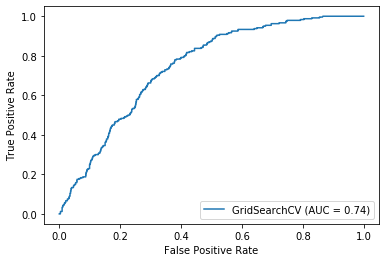

('abn_percent', 50970)                     0.097845
('abn_percent', 51006)                     0.097659
('abn_percent', 50912)                     0.085239
('abn_percent', 51277)                     0.085213
('abn_percent', 51237)                     0.075249
('abn_percent', 51222)                     0.071849
('abn_percent', 50902)                     0.069697
('abn_percent', 51274)                     0.054896
('abn_percent', 51249)                     0.054346
('abn_percent', 51003)                     0.051364
('abn_percent', 51275)                     0.050870
('abn_percent', 50882)                     0.034744
('abn_percent', 51250)                     0.031043
('abn_percent', 51265)                     0.028339
('abn_percent', 51248)                     0.016332
('abn_percent', 50971)                     0.015407
age                                        0.014550
('abn_percent', 50983)                     0.009082
('abn_percent', 50868)                     0.008894
('abn_percen

In [79]:
param_grid={'n_estimators':range(50,51,1),
            'max_depth':range(5,16,4),
            'min_samples_split':range(20,100,30),
            'max_features':range(7,20,5),
            }

grid_gb_under = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3)
grid_gb_under.fit(X_res_under, y_res_under)

results(grid_gb_under)


## Gather Metrics

In [128]:
def gather_metrics(model_list):
    '''
    Gathers metrics from models in model_list and returns a dataframe of gathered metrics.
    '''
    metrics = pd.DataFrame(columns = ['Model','Sampling','F1','ROC_AUC','Recall','Accuracy','Precision'])
    sampling_types = ['None','Under Sample','Over Sample']
    counter=0
    
    for model in model_list:
        pred = model.best_estimator_.predict(X_test)
        
        f1 = f1_score(y_test, pred)
        roc_auc = roc_auc_score(y_test, pred)
        recall = recall_score(y_test, pred)
        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred)
        
        model_name = type(model.estimator).__name__
        sampling = sampling_types[counter%3]
        counter += 1
        
        metrics = metrics.append({'Model':model_name,
                                  "Sampling":sampling,
                                  'F1':f1,
                                  'ROC_AUC':roc_auc,
                                  'Recall':recall,
                                  'Accuracy':accuracy,
                                  'Precision':precision}
                                 ,ignore_index=True)        
    return metrics

In [129]:
model_list=[grid_log, grid_log_under, grid_log_over,
            grid_gb, grid_gb_under, grid_gb_over,
            grid_rf, grid_rf_under, grid_rf_over
           ]
gather_metrics(model_list)

,Model,Sampling,F1,ROC_AUC,Recall,Accuracy,Precision
0,LogisticRegression,None,0.490667,0.775243,0.766667,0.781465,0.360784
1,LogisticRegression,Under Sample,0.316312,0.650591,0.929167,0.448513,0.190598
2,LogisticRegression,Over Sample,0.473458,0.746933,0.687500,0.790046,0.361050
3,GradientBoostingClassifier,None,0.358824,0.614152,0.254167,0.875286,0.610000
4,GradientBoostingClassifier,Under Sample,0.327965,0.667595,0.933333,0.474828,0.198934
5,GradientBoostingClassifier,Over Sample,0.462222,0.681521,0.433333,0.861556,0.495238
6,RandomForestClassifier,None,0.260274,0.574525,0.158333,0.876430,0.730769
7,RandomForestClassifier,Under Sample,0.343701,0.686876,0.920833,0.517162,0.211281
8,RandomForestClassifier,Over Sample,0.481172,0.698801,0.479167,0.858124,0.483193


## Gather Best Features

In [151]:
def gather_best_features(model_list):
    best_features = pd.DataFrame()
    sampling_types = ['None','Under Sample','Over Sample']
    
    counter=0
    for model in model_list:
        if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
            est_coefs = pd.Series(grid_log.best_estimator_.coef_[0], index=X_train.columns)
        else:
            est_coefs = pd.Series(model.best_estimator_.feature_importances_, index=X_train.columns)
            
        sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)

        model_name = type(model.estimator).__name__
        sampling = sampling_types[counter%3]
        model_string = model_name+sampling
        counter += 1

        sorted_df = pd.DataFrame(sortedCoefs).reset_index().rename(columns={"index":'features', 0: model_string})
        best_features = pd.concat([best_features, sorted_df], axis=1)
    return best_features

In [152]:
gather_best_features(model_list)

,features,LogisticRegressionNone,features,LogisticRegressionUnder Sample,features,LogisticRegressionOver Sample,features,GradientBoostingClassifierNone,features,GradientBoostingClassifierUnder Sample,features,GradientBoostingClassifierOver Sample,features,RandomForestClassifierNone,features,RandomForestClassifierUnder Sample,features,RandomForestClassifierOver Sample
0,age,0.808105,age,0.808105,age,0.808105,"('abn_percent', 51006)",0.257606,"('abn_percent', 50970)",0.097845,"('abn_percent', 51006)",0.308569,age,0.119673,"('abn_percent', 51006)",0.102273,age,0.122055
1,"('abn_percent', 51006)",0.419693,"('abn_percent', 51006)",0.419693,"('abn_percent', 51006)",0.419693,"('abn_percent', 51003)",0.149878,"('abn_percent', 51006)",0.097659,age,0.120194,"('abn_percent', 51006)",0.110407,"('abn_percent', 51274)",0.096412,"('abn_percent', 51006)",0.105905
2,"('abn_percent', 51277)",0.372782,"('abn_percent', 51277)",0.372782,"('abn_percent', 51277)",0.372782,age,0.106715,"('abn_percent', 50912)",0.085239,gender,0.065190,"('abn_percent', 50912)",0.082276,"('abn_percent', 50912)",0.088931,"('abn_percent', 50912)",0.076626
3,"('abn_percent', 51003)",0.348824,"('abn_percent', 51003)",0.348824,"('abn_percent', 51003)",0.348824,"('abn_percent', 51277)",0.098728,"('abn_percent', 51277)",0.085213,"('abn_percent', 50912)",0.046589,"('abn_percent', 51003)",0.065809,"('abn_percent', 51237)",0.085079,gender,0.045537
4,"('abn_percent', 51274)",0.296868,"('abn_percent', 51274)",0.296868,"('abn_percent', 51274)",0.296868,"('abn_percent', 50912)",0.068040,"('abn_percent', 51237)",0.075249,"('abn_percent', 50931)",0.033402,"('abn_percent', 51277)",0.049472,"('abn_percent', 51277)",0.071604,"('abn_percent', 51003)",0.045033
5,"('abn_percent', 51221)",0.291518,"('abn_percent', 51221)",0.291518,"('abn_percent', 51221)",0.291518,"('abn_percent', 51274)",0.033175,"('abn_percent', 51222)",0.071849,"('abn_percent', 50893)",0.032212,"('abn_percent', 50931)",0.039504,"('abn_percent', 50970)",0.064940,"('abn_percent', 51277)",0.041372
6,ethnicity_AMERICAN INDIAN/ALASKA NATIVE,0.289000,ethnicity_AMERICAN INDIAN/ALASKA NATIVE,0.289000,ethnicity_AMERICAN INDIAN/ALASKA NATIVE,0.289000,"('abn_percent', 51275)",0.032648,"('abn_percent', 50902)",0.069697,"('abn_percent', 51274)",0.028017,"('abn_percent', 51274)",0.036257,"('abn_percent', 50902)",0.056777,"('abn_percent', 50931)",0.040759
7,ethnicity_OTHER,0.276290,ethnicity_OTHER,0.276290,ethnicity_OTHER,0.276290,"('abn_percent', 51249)",0.028644,"('abn_percent', 51274)",0.054896,"('abn_percent', 51003)",0.026271,"('abn_percent', 51237)",0.036081,"('abn_percent', 50882)",0.043878,"('abn_percent', 50970)",0.040686
8,"('abn_percent', 51222)",0.241422,"('abn_percent', 51222)",0.241422,"('abn_percent', 51222)",0.241422,"('abn_percent', 50893)",0.022626,"('abn_percent', 51249)",0.054346,"('abn_percent', 50970)",0.025380,"('abn_percent', 50882)",0.032344,"('abn_percent', 51275)",0.043766,"('abn_percent', 50882)",0.037252
9,"('abn_percent', 50878)",0.214987,"('abn_percent', 50878)",0.214987,"('abn_percent', 50878)",0.214987,"('abn_percent', 50882)",0.019168,"('abn_percent', 51003)",0.051364,"('abn_percent', 51277)",0.023298,"('abn_percent', 50970)",0.029921,"('abn_percent', 51265)",0.038943,"('abn_percent', 51274)",0.033680
